In [47]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
from linreg import *
from bong.src import bbb, blr, bog, bong, experiment_utils
from bong.util import run_rebayes_algorithm, tune_init_hyperparam
from bong.util import plot_results, convert_result_dict_to_pandas

print(AGENT_TYPES)


['fg-bong', 'fg-l-bong', 'fg-rep-bong', 'fg-rep-l-bong', 'fg-blr', 'fg-bog', 'fg-rep-bog', 'fg-bbb', 'fg-rep-bbb']


In [50]:

#python  bong/experiments/kpm_linreg.py  --debug True

#python  experiments/kpm_linreg.py  --agents fg-bong --filename "foo_bar"
#python  experiments/kpm_linreg.py  --agents fg-bong fg-l-bong fg-blr fg-bog fg-bbb
#python  experiments/kpm_linreg.py  --agents fg-rep-bong fg-rep-l-bong fg-rep-bog fg-rep-bbb

import argparse

parser = argparse.ArgumentParser()
    
parser.add_argument("--num_examples", type=int, default=500)
parser.add_argument("--param_dim", type=int, default=10)
parser.add_argument("--key", type=int, default=0)
parser.add_argument("--emission_noise", type=float, default=1.0)

# Model parameters
parser.add_argument("--agents", type=str, nargs="+",
                  default=["fg-bong"], choices=AGENT_TYPES)
parser.add_argument("--num_samples", type=int, nargs="+", 
                  default=[10,])

parser.add_argument("--learning_rate", type=float, nargs="+", 
              default=[0.01])
parser.add_argument("--num_iter", type=int, nargs="+", 
              default=[10])
parser.add_argument("--tune_learning_rate", type=bool, default=False)
parser.add_argument("--debug", type=bool, default=False)
parser.add_argument("--filename", type=str, default="")



#https://stackoverflow.com/questions/30656777/how-to-call-module-written-with-argparse-in-ipython-notebook
#args = parser.parse_args()
args = parser.parse_args(args=[])
print(args)

#main(args)#


Namespace(num_examples=500, param_dim=10, key=0, emission_noise=1.0, agents=['fg-bong'], num_samples=[10], learning_rate=[0.01], num_iter=[10], tune_learning_rate=False, debug=False, filename='')


In [51]:
data, subkey = make_data(args)
init_kwargs, callback = init(args, data)
prior, post = compute_prior_post(args, data)
 

agent_queue, subkey = make_agent_queue(subkey, args, init_kwargs, None, data['X_tr'], data['Y_tr'])
result_dict = run_agents(subkey, agent_queue, data, callback)
  
root = "/Users/kpmurphy/github/bong/bong"
curr_path = Path(root, "results")


if args.filename == "":
    filename_prefix =  f"linreg_dim{args.param_dim}"
else:
    filename_prefix = args.filename
print("Saving results to", curr_path)
curr_path.mkdir(parents=True, exist_ok=True)




Running fg-bong-M10...
	KL-Div: 0.0844, Time: 0.48s
Saving results to /Users/kpmurphy/github/bong/bong/results


In [91]:

def parse_filename(s):
    # example filename: "fg-l-bong-M10-I10-LR0_01"
    s = s.replace("_", ".")
    import re
    pattern = r"^([a-z-]+)-M(\d+)-I(\d+)-LR(\d*\.?\d+)"
    match = re.match(pattern, s)
    if match:
        return {
            'prefix': match.group(1),
            'M': int(match.group(2)),
            'I': int(match.group(3)),
            'LR': float(match.group(4))
        }
    return {'prefix': None, 'M': None, 'I': None, 'LR': None}

def test_parse_filename():
    strings = ["fg-bong-M10-I1-LR0", "fg-l-bong-M10-I10-LR0_01"]
    for string in strings:
        res = parse_filename(string)
        print(res)

test_parse_filename()

{'prefix': 'fg-bong', 'M': 10, 'I': 1, 'LR': 0.0}
{'prefix': 'fg-l-bong', 'M': 10, 'I': 10, 'LR': 0.01}


In [92]:
import pandas as pd

# Sample DataFrame
data = {
    'name': [
        "fg-bong-M10-I1-LR0", "fg-bong-M10-I1-LR0", "fg-bong-M10-I1-LR0",
        "fg-blr-M10-I10-LR0_01", "fg-blr-M10-I10-LR0_01", "fg-blr-M10-I10-LR0_01",
        "fg-blr-M10-I10-LR0_05", "fg-blr-M10-I10-LR0_05", "fg-blr-M10-I10-LR0_05"
    ],
    'step': [0, 1, 2, 0, 1, 2, 0, 1, 2],
    'kl': [4715.3643, 4649.6323, 4704.921, 4637.003, 4708.9194, 4677.56, 4622.0254, 4707.8594, 4647.589],
    'nll': [0.829247, 0.8394967, 0.84964615, 0.829247, 0.83029026, 0.8313881, 0.829247, 0.8334199, 0.83842194],
    'nlpd': [1.0150638, 1.0070719, 1.00812, 0.98381305, 1.0121765, 1.0324197, 0.98617476, 1.0010813, 0.9961206],
    'time': [
        1.907885749998968, 1.907885749998968, 1.907885749998968,
        2.0240805419743992, 2.0240805419743992, 2.0240805419743992,
        2.021093249961268, 2.021093249961268, 2.021093249961268
    ]
}
df = pd.DataFrame(data)

# Apply the 'foo' function and expand the results into new DataFrame columns
df_expanded = df['name'].apply(parse_filename).apply(pd.Series)

# Join the new columns with the original DataFrame
df_final = df_expanded.join(df.drop('name', axis=1))

# Optionally, rearrange columns to match the desired output format
df_final = df_final[['prefix', 'M', 'I', 'LR', 'step', 'kl', 'nll', 'nlpd', 'time']]

print(df_final)


    prefix   M   I    LR  step         kl       nll      nlpd      time
0  fg-bong  10   1  0.00     0  4715.3643  0.829247  1.015064  1.907886
1  fg-bong  10   1  0.00     1  4649.6323  0.839497  1.007072  1.907886
2  fg-bong  10   1  0.00     2  4704.9210  0.849646  1.008120  1.907886
3   fg-blr  10  10  0.01     0  4637.0030  0.829247  0.983813  2.024081
4   fg-blr  10  10  0.01     1  4708.9194  0.830290  1.012177  2.024081
5   fg-blr  10  10  0.01     2  4677.5600  0.831388  1.032420  2.024081
6   fg-blr  10  10  0.05     0  4622.0254  0.829247  0.986175  2.021093
7   fg-blr  10  10  0.05     1  4707.8594  0.833420  1.001081  2.021093
8   fg-blr  10  10  0.05     2  4647.5890  0.838422  0.996121  2.021093


In [94]:
def split_filename_column(df):
    # If filename is fg-bong-M10-I1-LR0, we create columns name, M, I, LR with corresponding values
    # Apply the function to the 'name' column
    #new_cols = df['name'].apply(parse_filename).apply(pd.Series)
    # Join the new columns to the original DataFrame
    #result_df = new_cols.join(df.drop('name', axis=1))
    #return result_df

    # Apply the 'foo' function and expand the results into new DataFrame columns
    df_expanded = df['name'].apply(parse_filename).apply(pd.Series)

    # Join the new columns with the original DataFrame
    #df_final = df_expanded.join(df.drop('name', axis=1))
    df_final = df_expanded.join(df)

    # Optionally, rearrange columns to match the desired output format
    #df_final = df_final[['prefix', 'M', 'I', 'LR', 'step', 'kl', 'nll', 'nlpd', 'time']]
    return df_final

def test_split_filename_column():
    # Sample DataFrame
    data = {
        'name': [
            "fg-bong-M10-I1-LR0", "fg-bong-M10-I1-LR0", "fg-bong-M10-I1-LR0",
            "fg-blr-M10-I10-LR0_01", "fg-blr-M10-I10-LR0_01", "fg-blr-M10-I10-LR0_01",
            "fg-blr-M10-I10-LR0_05", "fg-blr-M10-I10-LR0_05", "fg-blr-M10-I10-LR0_05"
        ],
        'step': [0, 1, 2, 0, 1, 2, 0, 1, 2],
        'kl': [4715.3643, np.nan, 4704.921, 4637.003, 4708.9194, 4677.56, 4622.0254, 4707.8594, 4647.589],
        'nll': [0.829247, 0.8394967, 0.84964615, 0.829247, 0.83029026, 0.8313881, 0.829247, 0.8334199, 0.83842194],
        'nlpd': [1.0150638, 1.0070719, 1.00812, 0.98381305, 1.0121765, 1.0324197, 0.98617476, 1.0010813, 0.9961206],
        'time': [
            1.907885749998968, 1.907885749998968, 1.907885749998968,
            2.0240805419743992, 2.0240805419743992, 2.0240805419743992,
            2.021093249961268, 2.021093249961268, 2.021093249961268
        ]
    }
    df = pd.DataFrame(data)
    res = split_filename_column(df)
    print(res)

test_split_filename_column()

    prefix   M   I    LR  step         kl       nll      nlpd      time
0  fg-bong  10   1  0.00     0  4715.3643  0.829247  1.015064  1.907886
1  fg-bong  10   1  0.00     1        NaN  0.839497  1.007072  1.907886
2  fg-bong  10   1  0.00     2  4704.9210  0.849646  1.008120  1.907886
3   fg-blr  10  10  0.01     0  4637.0030  0.829247  0.983813  2.024081
4   fg-blr  10  10  0.01     1  4708.9194  0.830290  1.012177  2.024081
5   fg-blr  10  10  0.01     2  4677.5600  0.831388  1.032420  2.024081
6   fg-blr  10  10  0.05     0  4622.0254  0.829247  0.986175  2.021093
7   fg-blr  10  10  0.05     1  4707.8594  0.833420  1.001081  2.021093
8   fg-blr  10  10  0.05     2  4647.5890  0.838422  0.996121  2.021093


In [83]:
df = pd.read_csv("/Users/kpmurphy/github/bong/bong/results/foo_results.csv")
df.head(n=50)

,name,M,I,LR,step,kl,nll,nlpd,time
0,fg-bong,10,1,0.0,0,4715.3643,0.829247,1.015064,1.904113
1,fg-bong,10,1,0.0,0,4637.0030,0.829247,0.983813,1.998806
2,fg-bong,10,1,0.0,0,4622.0254,0.829247,0.986175,1.989403
3,fg-blr,10,10,0.0,0,4715.3643,0.829247,1.015064,1.904113
4,fg-blr,10,10,0.0,0,4637.0030,0.829247,0.983813,1.998806
5,fg-blr,10,10,0.0,0,4622.0254,0.829247,0.986175,1.989403
6,fg-blr,10,10,0.0,0,4715.3643,0.829247,1.015064,1.904113
7,fg-blr,10,10,0.0,0,4637.0030,0.829247,0.983813,1.998806
8,fg-blr,10,10,0.0,0,4622.0254,0.829247,0.986175,1.989403
9,fg-bong,10,1,0.0,1,4649.6323,0.839497,1.007072,1.904113


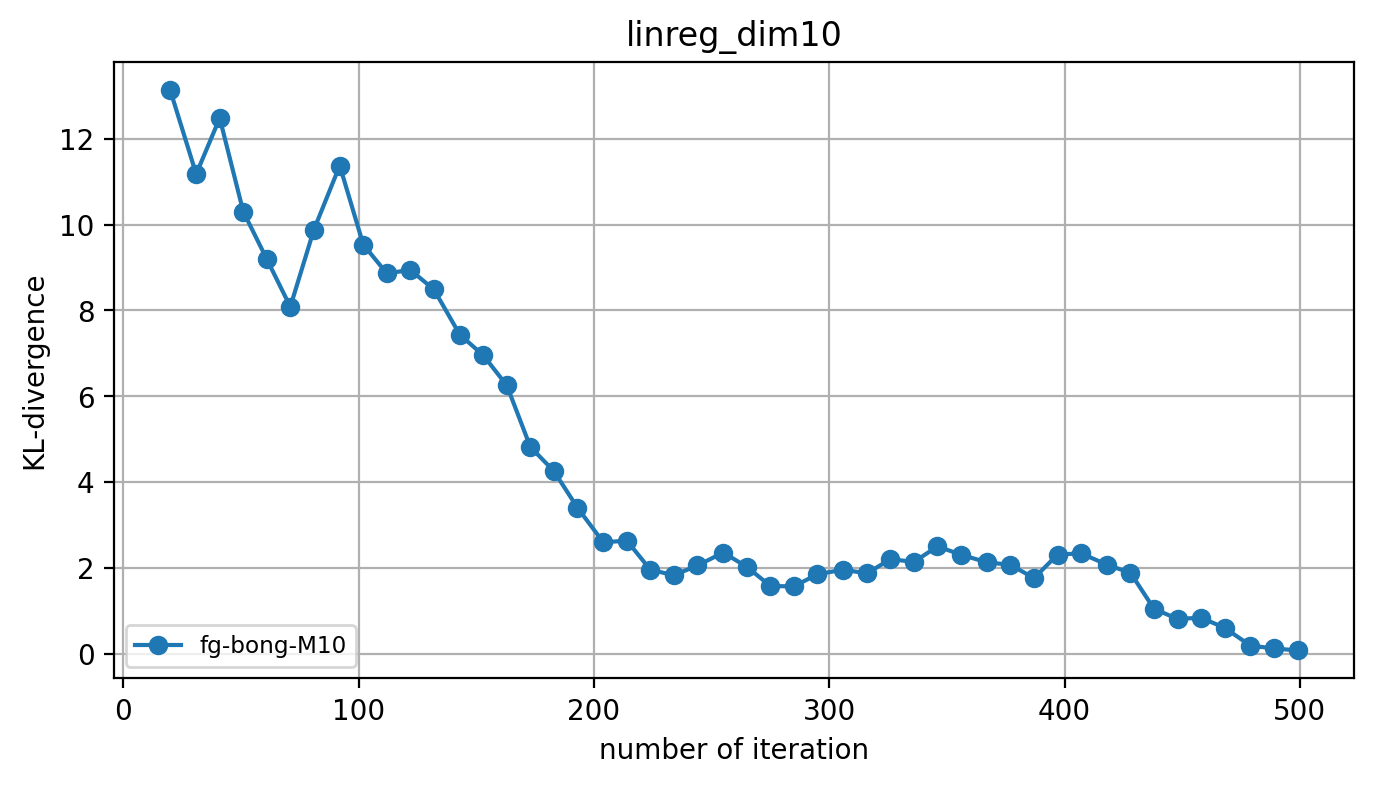

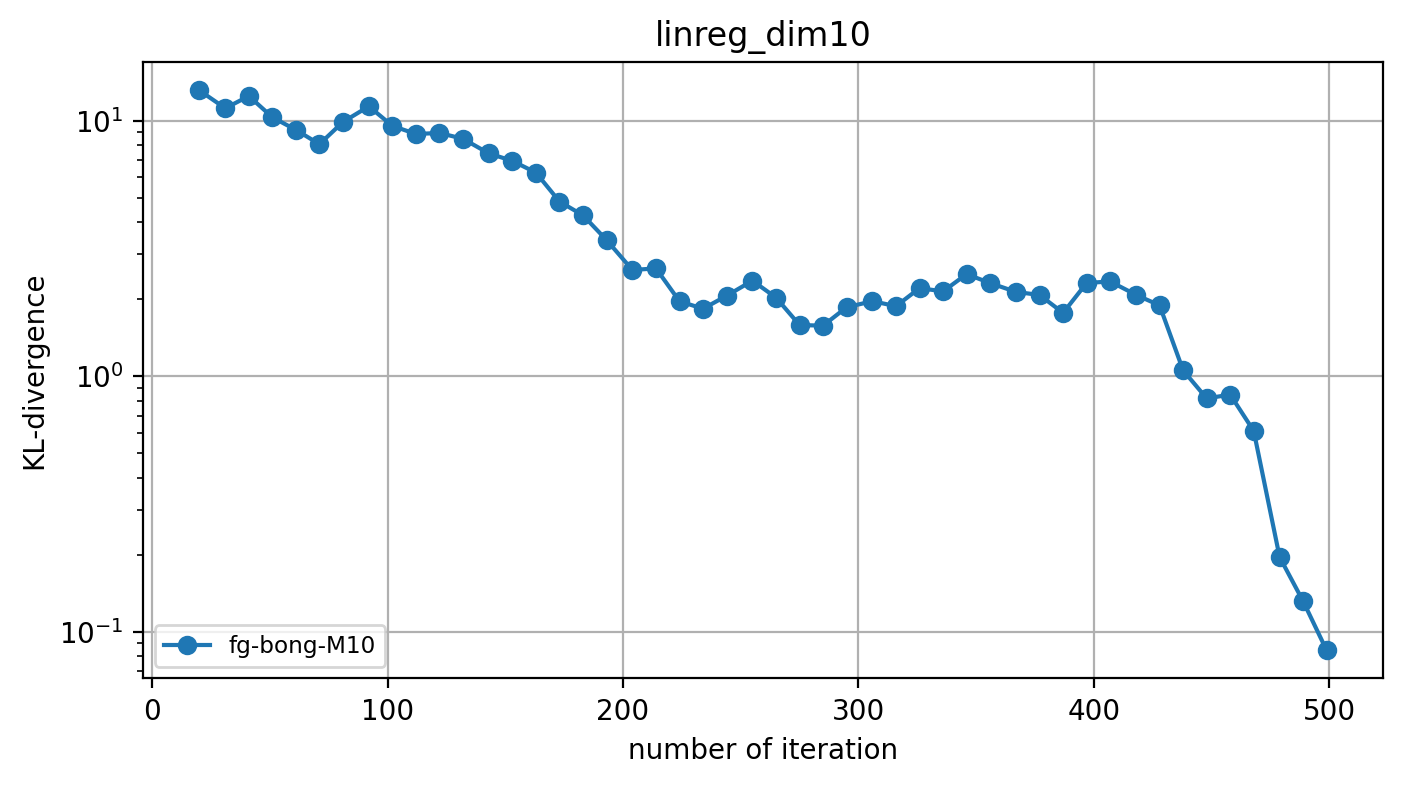

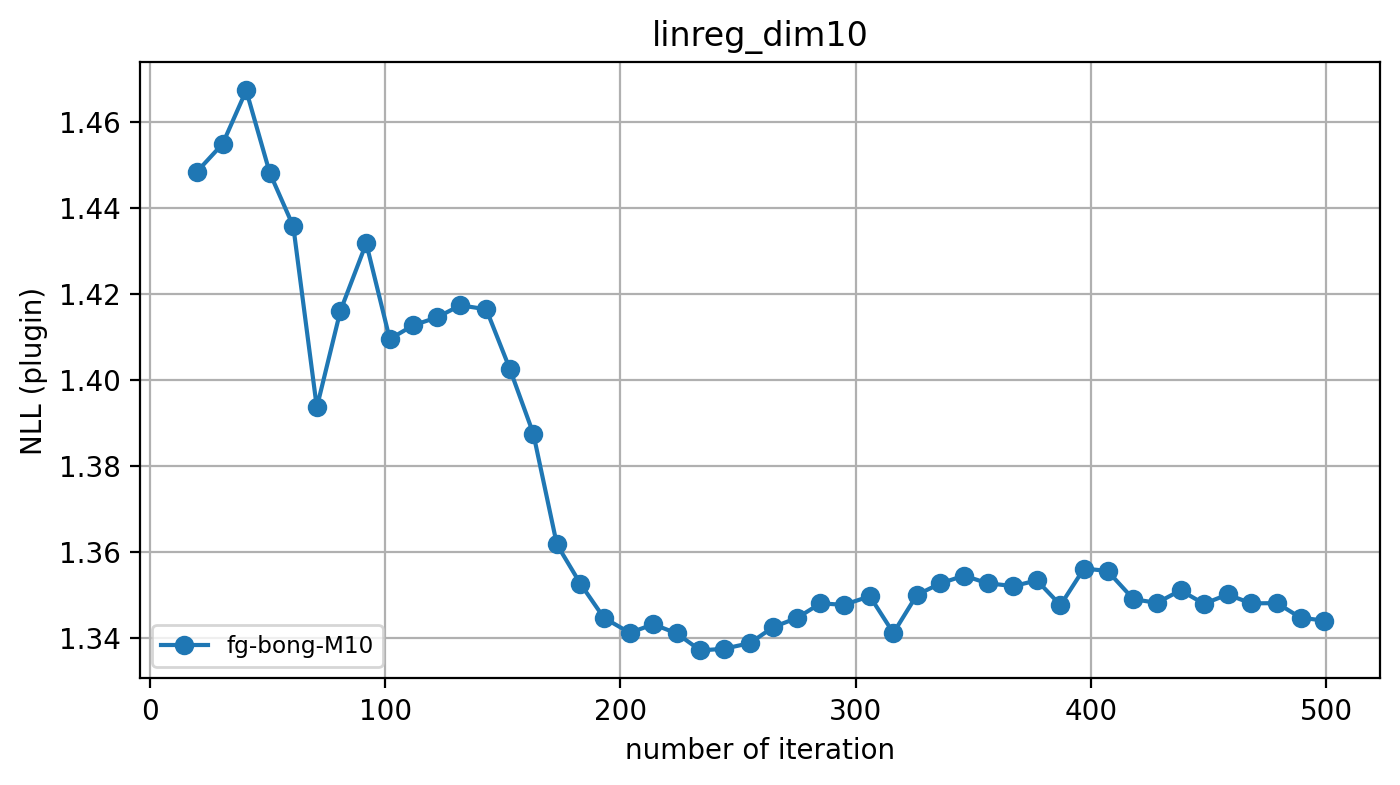

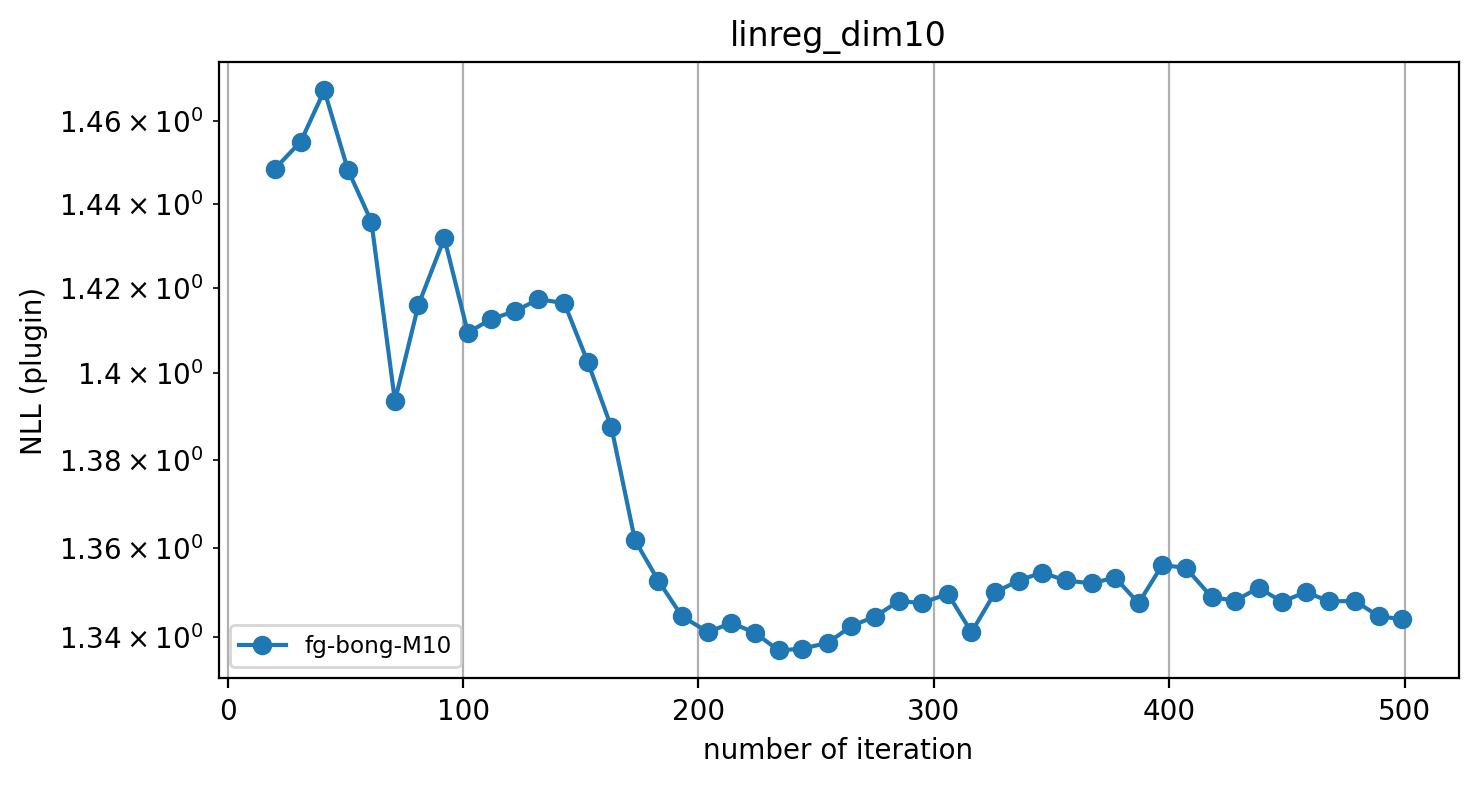

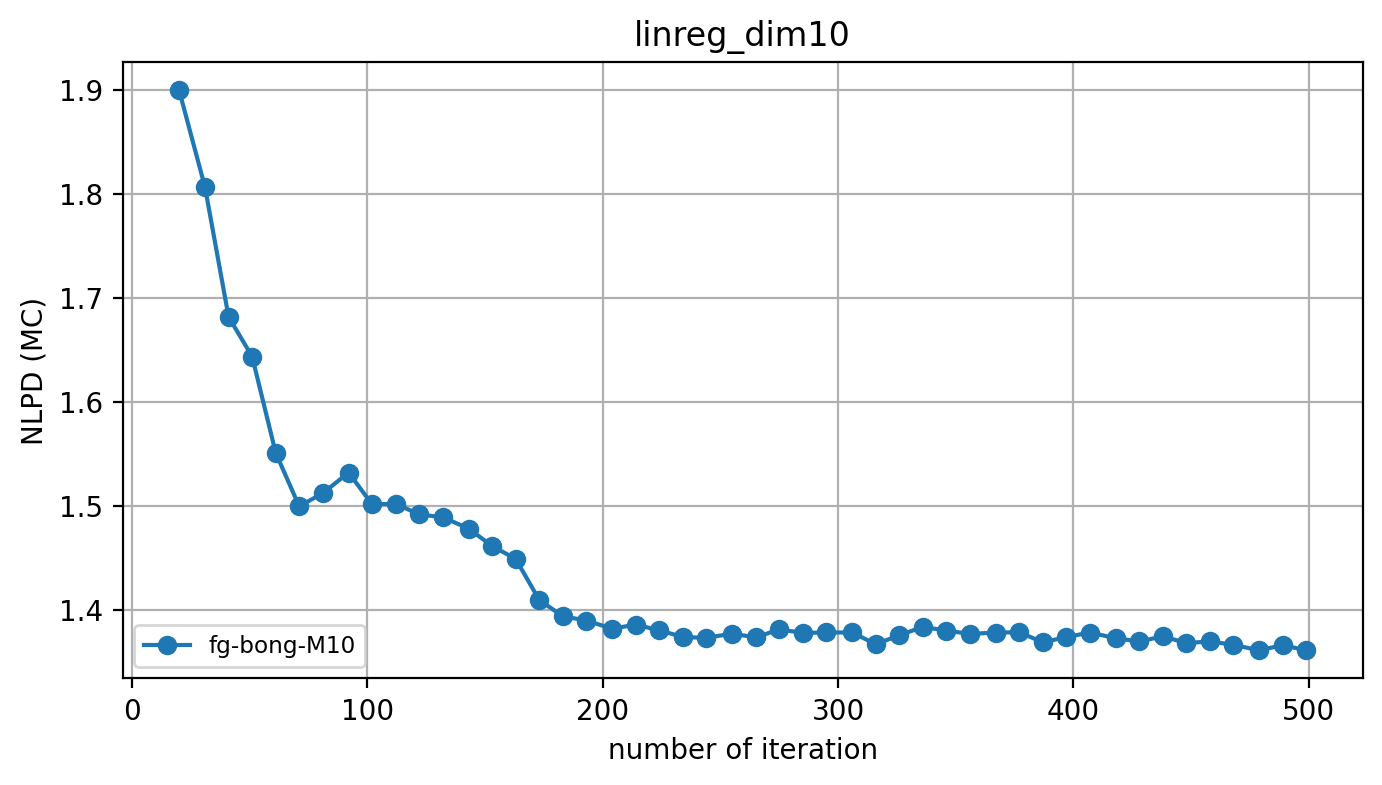

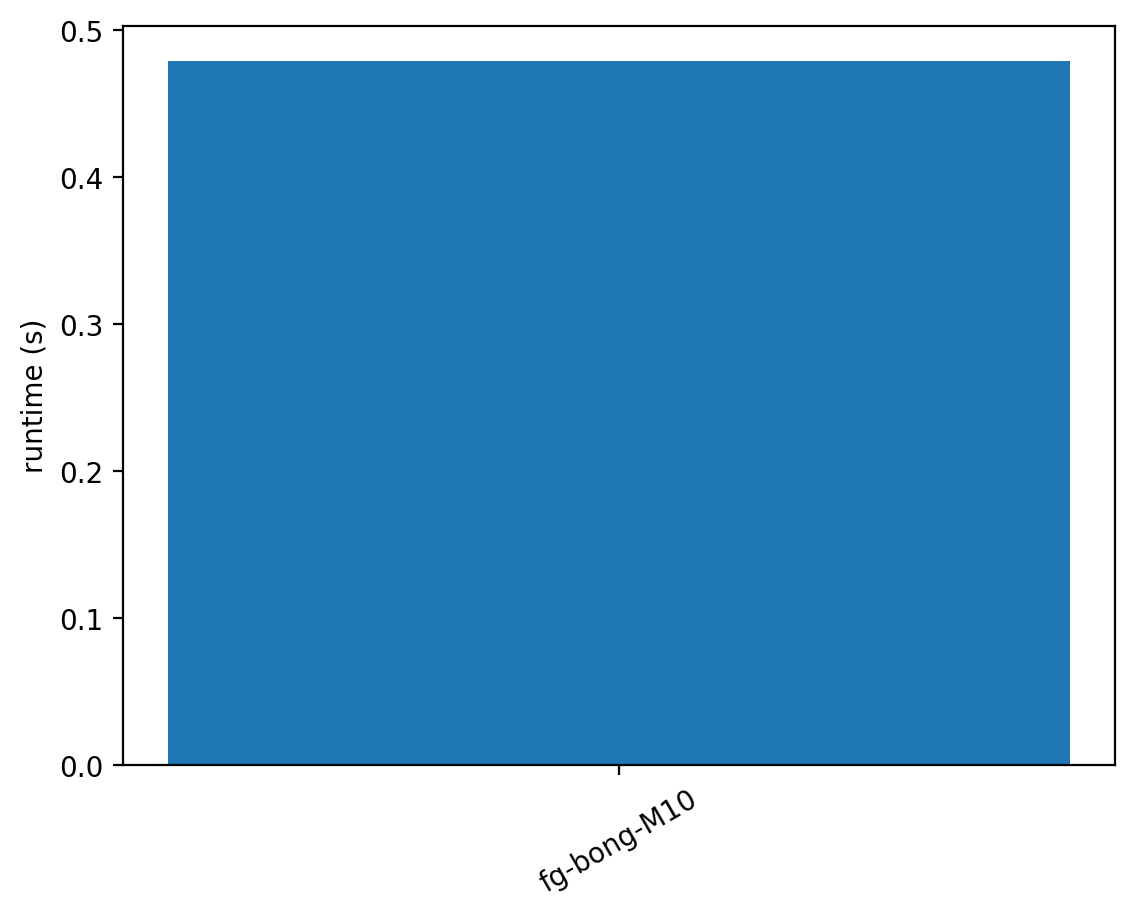

In [53]:
plot_results(args.num_examples, result_dict, curr_path, ttl=filename_prefix)


In [41]:

name  = 'fg-bong-MC100'
r = result_dict[name]
T = len(r[1])
print(T)
steps = list(range(0,T))
print(steps)

500
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 

In [46]:
names = list(result_dict.keys())
r = result_dict[names[0]]
(time, kldiv, nll, nlpd) = r
print(type(kldiv))
print(kldiv)
T = len(kldiv)
print(T)


<class 'jaxlib.xla_extension.ArrayImpl'>
[2.29508152e+01 2.26530933e+01 2.21118793e+01 2.17691097e+01
 2.12806187e+01 2.19830608e+01 2.20961857e+01 2.15139885e+01
 2.12678986e+01 2.01284199e+01 2.03432426e+01 2.15423794e+01
 1.87359543e+01 1.59252520e+01 1.48580227e+01 1.49974546e+01
 1.47855921e+01 1.46098967e+01 1.42634115e+01 1.35616045e+01
 1.35118504e+01 1.33153067e+01 1.32833652e+01 1.30214291e+01
 1.24199820e+01 1.26722755e+01 1.28465328e+01 1.25175886e+01
 1.16667442e+01 1.14129324e+01 1.16298437e+01 1.14548140e+01
 1.13177052e+01 1.13114128e+01 1.11856441e+01 1.21381168e+01
 1.13956718e+01 1.12784576e+01 1.12371140e+01 1.12015371e+01
 1.12403450e+01 1.12298899e+01 1.12290316e+01 1.11854773e+01
 1.08538933e+01 1.02355700e+01 9.66083813e+00 9.75895977e+00
 9.66352940e+00 9.72795677e+00 9.64918804e+00 9.61919689e+00
 9.55927181e+00 9.25253868e+00 9.19234848e+00 9.10633469e+00
 8.99569607e+00 8.82662296e+00 8.45674324e+00 8.37338257e+00
 8.30795956e+00 8.51406860e+00 8.45230579e+0

In [42]:
def convert_result_dict_to_pandas(result_dict):
    frames = []
    for name, r in result_dict.items():
        T = len(r[1])
        steps = range(0, T)
        df  = pd.DataFrame({'name': name,  'step': steps, 'kl': np.array(r[1]), 
                            'nll': np.array(r[2]), 'nlpd': np.array(r[3]),
                            'time': r[0],})
        frames.append(df)
    tbl = pd.concat(frames)
    return tbl

tbl = convert_result_dict_to_pandas(result_dict)
print(tbl)

                    name  step         kl       nll      nlpd      time
0          fg-bong-MC100     0  22.950815  2.368018  3.671783  0.462484
1          fg-bong-MC100     1  22.653093  2.680291  3.834912  0.462484
2          fg-bong-MC100     2  22.111879  2.720388  3.849871  0.462484
3          fg-bong-MC100     3  21.769110  2.730461  3.807554  0.462484
4          fg-bong-MC100     4  21.280619  2.525638  3.530576  0.462484
..                   ...   ...        ...       ...       ...       ...
495  fg-bbb-MC100-LR0_05   495        NaN       NaN       NaN  0.758399
496  fg-bbb-MC100-LR0_05   496        NaN       NaN       NaN  0.758399
497  fg-bbb-MC100-LR0_05   497        NaN       NaN       NaN  0.758399
498  fg-bbb-MC100-LR0_05   498        NaN       NaN       NaN  0.758399
499  fg-bbb-MC100-LR0_05   499        NaN       NaN       NaN  0.758399

[6500 rows x 6 columns]


In [43]:
tbl.to_csv('/Users/kpmurphy/github/bong/bong/results/foo.csv', index=False)

In [12]:
result_dict


{'fg-bong-MC100': (0.46248354198178276,
  Array([2.29508152e+01, 2.26530933e+01, 2.21118793e+01, 2.17691097e+01,
         2.12806187e+01, 2.19830608e+01, 2.20961857e+01, 2.15139885e+01,
         2.12678986e+01, 2.01284199e+01, 2.03432426e+01, 2.15423794e+01,
         1.87359543e+01, 1.59252520e+01, 1.48580227e+01, 1.49974546e+01,
         1.47855921e+01, 1.46098967e+01, 1.42634115e+01, 1.35616045e+01,
         1.35118504e+01, 1.33153067e+01, 1.32833652e+01, 1.30214291e+01,
         1.24199820e+01, 1.26722755e+01, 1.28465328e+01, 1.25175886e+01,
         1.16667442e+01, 1.14129324e+01, 1.16298437e+01, 1.14548140e+01,
         1.13177052e+01, 1.13114128e+01, 1.11856441e+01, 1.21381168e+01,
         1.13956718e+01, 1.12784576e+01, 1.12371140e+01, 1.12015371e+01,
         1.12403450e+01, 1.12298899e+01, 1.12290316e+01, 1.11854773e+01,
         1.08538933e+01, 1.02355700e+01, 9.66083813e+00, 9.75895977e+00,
         9.66352940e+00, 9.72795677e+00, 9.64918804e+00, 9.61919689e+00,
         9.